# 05wk-2: (신경망) – 신경망의 표현, GPU사용법, 확률적경사하강법

최규빈  
2025-04-07

<a href="https://colab.research.google.com/github/guebin/DL2025/blob/main/posts/05wk-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

In [2]:
# {{<video https://youtu.be/playlist?list=PLQqh36zP38-yx6DQsLACqw8pWm0udv8Jm&si=in1eMD0-wU49y7mS >}}

# 2. Imports

In [59]:
import torch
import matplotlib.pyplot as plt
import torchvision

In [5]:
plt.rcParams['figure.figsize'] = (4.5, 3.0)

# 3. 신경망의 표현

신경망의 표현: ${\boldsymbol x} \to \hat{\boldsymbol y}$ 로 가는 과정을
그림으로 표현

## A. 로지스틱

$$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(1)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(1)}} =\underset{(n,1)}{\hat{\boldsymbol y}}$$

`-` 모든 observation과 가중치를 명시한 버전

**(표현1)**

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-4-output-1.svg)

-   단점: 똑같은 그림의 반복이 너무 많음

`-` observation 반복을 생략한 버전들

**(표현2)** 모든 $i$에 대하여 아래의 그림을 반복한다고 하면 (표현1)과
같다.

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-5-output-1.svg)

**(표현3)** 그런데 (표현2)에서 아래와 같이 $x_i$, $y_i$ 대신에 간단히
$x$, $y$로 쓰는 경우도 많음

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-6-output-1.svg)

`-` 1을 생략한 버전들

**(표현4)** bais=False 대신에 bias=True를 주면 1을 생략할 수 있음

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-7-output-1.svg)

**(표현4의 수정)** $\hat{w}_1$대신에 $\hat{w}$를 쓰는 것이 더 자연스러움

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-8-output-1.svg)

**(표현5)** 선형변환의 결과는 아래와 같이 $u$로 표현하기도 한다.

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-9-output-1.svg)

> 다이어그램은 그리는 사람의 취향에 따라 그리는 방법이 조금씩 다릅니다.
> 즉 교재마다 달라요.

## B. 스펙의역설

$$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,2)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,2)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}} =\underset{(n,1)}{\hat{\boldsymbol y}}$$

**참고: 코드로 표현**

``` python
torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=2),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=2,out_features=1),
    torch.nn.Sigmoid()
)
```

`-` 이해를 위해서 예젠에 다루었던 아래의 상황을 고려하자.

![](https://guebin.github.io/DL2024/posts/03wk-2_files/figure-html/cell-11-output-1.png)

**(강의노트의 표현)**

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-10-output-1.svg)

**(좀 더 일반화된 표현)** 상황을 일반화하면 아래와 같다.

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-11-output-1.svg)

`*` Layer의 개념: ${\bf X}$에서 $\hat{\boldsymbol y}$로 가는 과정은
“선형변환+비선형변환”이 반복되는 구조이다. “선형변환+비선형변환”을
하나의 세트로 보면 아래와 같이 표현할 수 있다.

-   $\underset{(n,1)}{\bf X}  \overset{l_1}{\to} \left( \underset{(n,2)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,2)}{\boldsymbol v^{(1)}} \right) \overset{l_2}{\to} \left(\underset{(n,1)}{\boldsymbol u^{(2)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}\right), \quad  \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{net({\bf X})}=\underset{(n,1)}{\hat{\boldsymbol y}}$

이것을 다이어그램으로 표현한다면 아래와 같다.

**(선형+비선형을 하나의 Layer로 묶은 표현)**

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-12-output-1.svg)

***Layer를 세는 방법***

-   제 방식: 학습가능한 파라메터가 몇층으로 있는지… \<– 이것만
    기억하세여
-   일부 교재 설명: 입력층은 계산하지 않음, activation layer는 계산하지
    않음. \<– 무시하세요.. 이러면 헷갈립니다..
-   위의 예제의 경우 `number of layer = 2` 이다.

***Hidden Layer의 수를 세는 방법***

-   제 방식: `Hidden Layer의 수 = Layer의 수 -1` \<– 이걸 기억하세여..  
-   일부 교재 설명:
    `Layer의 수 = Hidden Layer의 수 + 출력층의 수 = Hidden Layer의 수 + 1`
    \<– 기억하지 마세여
-   위의 예제의 경우 `number of hidden layer = 1` 이다.

> **Important**
>
> 무조건 학습가능한 파라메터가 몇겹으로 있는지만 판단하세요. 딴거
> 아무것도 생각하지마세여
>
> ``` python
> ## 예시1 -- 2층 (히든레이어는 1층)
> torch.nn.Sequential(
>     torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
>     torch.nn.ReLU(),
>     torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
> )
> ```
>
> ``` python
> ## 예시2 -- 2층 (히든레이어는 1층)
> torch.nn.Sequential(
>     torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
>     torch.nn.ReLU(),
>     torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
>     torch.nn.Sigmoid(),
> )
> ```
>
> ``` python
> ## 예시3 -- 1층 (히든레이어는 없음!!)
> torch.nn.Sequential(
>     torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
> ) 
> ```
>
> ``` python
> ## 예시4 -- 1층 (히든레이어는 없음!!)
> torch.nn.Sequential(
>     torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
>     torch.nn.Sigmoid()
> ) 
> ```
>
> ``` python
> ## 예시5 -- 3층 (히든레이어는 2층)
> torch.nn.Sequential(
>     torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
>     torch.nn.Sigmoid()
>     torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
>     torch.nn.Sigmoid()
>     torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층    
> ) 
> ```
>
> ``` python
> ## 예시6 -- 3층 (히든레이어는 2층)
> torch.nn.Sequential(
>     torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
>     torch.nn.ReLU()
>     torch.nn.Dropout(??)
>     torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
>     torch.nn.ReLU()
>     torch.nn.Dropout(??)
>     torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층  
>     torch.nn.Sigmoid()
> ) 
> ```

> **Important**
>
> 문헌에 따라서 레이어를 세는 개념이 제가 설명한 방식과 다른경우가
> 있습니다. 제가 설명한 방식보다 1씩 더해서 셉니다. 즉 아래의 경우
> 레이어를 3개로 카운트합니다.
>
> ``` python
> ## 예시1 -- 문헌에 따라 3층으로 세는 경우가 있음 (히든레이어는 1층)
> torch.nn.Sequential(
>     torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
>     torch.nn.ReLU(),
>     torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
>     torch.nn.Sigmoid()
> )
> ```
>
> 예를 들어
> [여기](https://en.wikipedia.org/wiki/Multilayer_perceptron#Layers)에서는
> 위의 경우 레이어는 3개라고 설명하고 있습니다. 이러한 카운팅은
> **“무시”하세요. 제가 설명한 방식이 맞아요.** [이
> 링크](https://en.wikipedia.org/wiki/Multilayer_perceptron#Layers)
> 잘못(?) 나와있는 이유는 아래와 같습니다.
>
> `-` 진짜 예전에 MLP를 소개할 초창기에서는 위의 경우 Layer를 3개로
> 셌음. (Rosenblatt et al. 1962)
>
> `-` 그런데 요즘은 그렇게 안셈.. (그리고 애초에 MLP라는 용어도 잘
> 안쓰죠..)
>
> 참고로 히든레이어의 수는 예전방식이나 지금방식이나 동일하게
> 카운트하므로 히든레이어만 세면 혼돈이 없습니다.

`*` node의 개념: $u\to v$로 가는 쌍을 간단히 노드라는 개념을 이용하여
나타낼 수 있음.

**(노드의 개념이 포함된 그림)**

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-13-output-1.svg)

여기에서 `node의 숫자 = feature의 숫자`와 같이 이해할 수 있다. 즉 아래와
같이 이해할 수 있다.

**(“number of nodes = number of features”로 이해한 그림)**

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-14-output-1.svg)

> 다이어그램의 표현방식은 교재마다 달라서 모든 예시를 달달 외울 필요는
> 없습니다. 다만 임의의 다이어그램을 보고 대응하는 네트워크를 pytorch로
> 구현하는 능력은 매우 중요합니다.

## C. MNIST

$$\underset{(n,784)}{\bf X} \overset{l_1}{\to} \underset{(n,32)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,32)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$$

**(다이어그램표현)**

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-15-output-1.svg)

-   Layer0,1,2 대신에 Input Layer, Hidden Layer, Output Layer로 표현함

`-` 위의 다이어그램에 대응하는 코드

``` python
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=28*28*1,out_features=32),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=32,out_features=1),
    torch.nn.Sigmoid() 
)
```

# 4. CPU vs GPU

`-` 파이토치에서 GPU를 쓰는 방법을 알아보자. (사실 지금까지 우리는 CPU만
쓰고 있었음)

`-` 코랩에서 GPU설정하는 방법: (아래영상참고)

<https://youtu.be/GyBL2YBCzoc>

## A. GPU 사용방법

`-` cpu 연산이 가능한 메모리에 데이터 저장

In [6]:
torch.manual_seed(43052)
x_cpu = torch.tensor([0.0,0.1,0.2]).reshape(-1,1) 
y_cpu = torch.tensor([0.0,0.2,0.4]).reshape(-1,1) 
net_cpu = torch.nn.Linear(1,1) 

`-` gpu 연산이 가능한 메모리에 데이터 저장

In [7]:
!nvidia-smi # before

Mon Apr  7 09:48:42 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.230.02             Driver Version: 535.230.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:09:00.0 Off |                  N/A |
|  0%   29C    P8              27W / 420W |     26MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [8]:
torch.manual_seed(43052)
x_gpu = x_cpu.to("cuda:0")
y_gpu = y_cpu.to("cuda:0")
net_gpu = torch.nn.Linear(1,1).to("cuda:0") 

In [9]:
!nvidia-smi

Mon Apr  7 09:48:43 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.230.02             Driver Version: 535.230.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:09:00.0 Off |                  N/A |
|  0%   34C    P2              65W / 420W |    287MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

> GPU에 메모리를 올리면 GPU메모리가 점유된다! (26MiB -\> 287MiB)

`-` cpu 혹은 gpu 연산이 가능한 메모리에 저장된 값들을 확인

In [10]:
x_cpu, y_cpu, net_cpu.weight, net_cpu.bias

In [11]:
x_gpu, y_gpu, net_gpu.weight, net_gpu.bias

`-` gpu는 gpu끼리 연산가능하고 cpu는 cpu끼리 연산가능함

(예시1)

In [12]:
net_cpu(x_cpu) 

(예시2)

In [13]:
net_gpu(x_gpu) 

(예시3)

In [14]:
net_cpu(x_gpu) 

(예시4)

In [15]:
net_gpu(x_cpu)

(예시5)

In [16]:
torch.mean((y_cpu-net_cpu(x_cpu))**2)

(예시6)

In [17]:
torch.mean((y_gpu-net_gpu(x_gpu))**2)

(예시7)

In [18]:
torch.mean((y_gpu-net_cpu(x_cpu))**2)

(예시8)

In [19]:
torch.mean((y_cpu-net_gpu(x_gpu))**2)

## B. 시간측정 (예비학습)

In [20]:
import time 

In [21]:
t1 = time.time()

In [22]:
t2 = time.time()

In [23]:
t2-t1

## C. CPU vs GPU (500 nodes)

`-` CPU (500 nodes)

In [24]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(-1,1)
y=torch.randn(100).reshape(-1,1)*0.01
#---#
net = torch.nn.Sequential(
    torch.nn.Linear(1,500),
    torch.nn.ReLU(),
    torch.nn.Linear(500,1)
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
t1 = time.time()
for epoc in range(1000):
    # 1 
    yhat = net(x)
    # 2 
    loss = loss_fn(yhat,y)
    # 3 
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

`-` GPU (500 nodes)

In [25]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(-1,1).to("cuda:0")
y=(torch.randn(100).reshape(-1,1)*0.01).to("cuda:0")
#---#
net = torch.nn.Sequential(
    torch.nn.Linear(1,500),
    torch.nn.ReLU(),
    torch.nn.Linear(500,1)
).to("cuda:0")
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
t1 = time.time()
for epoc in range(1000):
    # 1 
    yhat = net(x)
    # 2 
    loss = loss_fn(yhat,y)
    # 3 
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

-   CPU가 더 빠르다??

## D. CPU vs GPU (200,000 nodes)

`-` CPU (200,000)

In [25]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(-1,1)
y=torch.randn(100).reshape(-1,1)*0.01
#---#
net = torch.nn.Sequential(
    torch.nn.Linear(1,200000),
    torch.nn.ReLU(),
    torch.nn.Linear(200000,1)
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
t1 = time.time()
for epoc in range(1000):
    # 1 
    yhat = net(x)
    # 2 
    loss = loss_fn(yhat,y)
    # 3 
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

`-` GPU (204,800)

In [26]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(-1,1).to("cuda:0")
y=(torch.randn(100).reshape(-1,1)*0.01).to("cuda:0")
#---#
net = torch.nn.Sequential(
    torch.nn.Linear(1,200000),
    torch.nn.ReLU(),
    torch.nn.Linear(200000,1)
).to("cuda:0")
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
t1 = time.time()
for epoc in range(1000):
    # 1 
    yhat = net(x)
    # 2 
    loss = loss_fn(yhat,y)
    # 3 
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

-   왜 이런 차이가 나는가?
-   연산을 하는 주체는 코어인데 CPU는 수는 적지만 일을 잘하는 코어들을
    가지고 있고 GPU는 일은 못하지만 다수의 코어를 가지고 있기 때문

## E. 주의점

`-` tensor 일 경우

In [31]:
x = torch.tensor([1,2,3])
x.to("cuda:0"), x

`-` net일 경우

In [34]:
net = torch.nn.Linear(1,1).to("cuda:0")
net.weight, net.bias

# 5. “확률적” 경사하강법

## A. 의문: 좀 이상하지 않아요?

`-` 국민상식: GPU 비싸요..
<https://bbs.ruliweb.com/community/board/300143/read/61066881>

-   GPU 메모리 많아봐야 24GB, 그래도 비싸요..
    <http://shop.danawa.com/virtualestimate/?controller=estimateMain&methods=index&marketPlaceSeq=16>
-   GPU 메모리가 80GB일 경우 가격:
    <https://prod.danawa.com/info/?pcode=21458333>

`-` 우리가 분석하는 데이터: 빅데이터..?

In [39]:
x = torch.linspace(-10,10,100000).reshape(-1,1)
eps = torch.randn(100000).reshape(-1,1)
y = x*2 + eps 

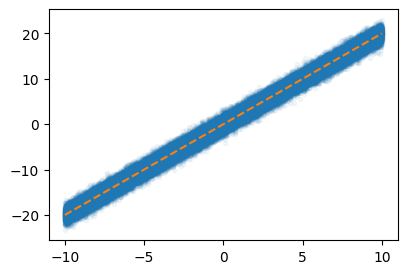

In [40]:
plt.plot(x,y,'.',alpha=0.05)
plt.plot(x,2*x,'--')

`-` 데이터의 크기가 커지는 순간 `x.to("cuda:0")`, `y.to("cuda:0")` 쓰면
난리나겠는걸?

`-` 데이터를 100개중에 1개만 꼴로만 쓰면 어떨까?

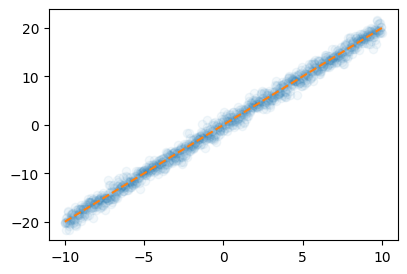

In [41]:
plt.plot(x[::100],y[::100],'o',alpha=0.05)
plt.plot(x,2*x,'--')

-   대충 이거만 가지고 적합해도 충분히 정확할것 같은데?

## B. X,y 데이터를 굳이 모두 GPU에 넘겨야 하는가?

`-` 데이터셋을 짝홀로 나누어서 번갈아가면서 GPU에 올렸다 내렸다하면
안되나?

`-` 아래의 알고리즘을 생각해보자.

1.  데이터를 반으로 나눈다.
2.  짝수obs의 x,y 그리고 net의 모든 파라메터를 GPU에 올린다.
3.  yhat, loss, grad, update 수행
4.  짝수obs의 x,y를 GPU메모리에서 내린다. 그리고 홀수obs의 x,y를
    GPU메모리에 올린다.
5.  yhat, loss, grad, update 수행
6.  홀수obs의 x,y를 GPU메모리에서 내린다. 그리고 짝수obs의 x,y를
    GPU메모리에 올린다.
7.  반복

> 이러면 되는거아니야???? —\> 맞아요

## C. 경사하강법, 확률적경사하강법, 미니배치 경사하강법

10개의 샘플이 있다고 가정. $\{(x_i,y_i)\}_{i=1}^{10}$

`# ver1` – 모든 샘플을 이용하여 slope 계산

(epoch 1)
$loss=\sum_{i=1}^{10}(y_i-\hat{w}_0-\hat{w}_1x_i)^2 \to slope  \to update$

(epoch 2)
$loss=\sum_{i=1}^{10}(y_i-\hat{w}_0-\hat{w}_1x_i)^2 \to slope  \to update$

…

> 우리가 항상 이렇게 했죠!

`# ver2` – 하나의 샘플만을 이용하여 slope 계산

(epoch 1)

-   $loss=(y_1-\hat{w}_0-\hat{w}_1x_1)^2 \to slope \to update$
-   $loss=(y_2-\hat{w}_0-\hat{w}_1x_2)^2 \to slope \to update$
-   …
-   $loss=(y_{10}-\hat{w}_0-\hat{w}_1x_{10})^2  \to  slope  \to  update$

(epoch 2)

-   $loss=(y_1-\hat{w}_0-\hat{w}_1x_1)^2  \to slope  \to  update$
-   $loss=(y_2-\hat{w}_0-\hat{w}_1x_2)^2  \to slope  \to  update$
-   …
-   $loss=(y_{10}-\hat{w}_0-\hat{w}_1x_{10})^2  \to  slope  \to  update$

…

`# ver3` – $m (\leq n)$ 개의 샘플을 이용하여 slope 계산

$m=3$이라고 하자.

(epoch 1)

-   $loss=\sum_{i=1}^{3}(y_i-\hat{w}_0-\hat{w}_1x_i)^2  \to  slope  \to  update$
-   $loss=\sum_{i=4}^{6}(y_i-\hat{w}_0-\hat{w}_1x_i)^2  \to  slope  \to  update$
-   $loss=\sum_{i=7}^{9}(y_i-\hat{w}_0-\hat{w}_1x_i)^2  \to  slope  \to  update$
-   $loss=(y_{10}-\hat{w}_0-\hat{w}_1x_{10})^2  \to  slope  \to  update$

(epoch 2)

-   $loss=\sum_{i=1}^{3}(y_i-\hat{w}_0-\hat{w}_1x_i)^2  \to  slope  \to  update$
-   $loss=\sum_{i=4}^{6}(y_i-\hat{w}_0-\hat{w}_1x_i)^2  \to  slope  \to  update$
-   $loss=\sum_{i=7}^{9}(y_i-\hat{w}_0-\hat{w}_1x_i)^2  \to  slope  \to  update$
-   $loss=(y_{10}-\hat{w}_0-\hat{w}_1x_{10})^2  \to  slope  \to  update$

…

## D. 용어의 정리

**옛날**

`-` ver1(모든): gradient descent, batch gradient descent

`-` ver2(하나만): stochastic gradient descent

`-` ver3(몇개만): mini-batch gradient descent, mini-batch stochastic
gradient descent

**요즘**

`-` ver1(모든): gradient descent

`-` ver2(하나만): stochastic gradient descent with batch size = 1

`-` **ver3(몇개만): stochastic gradient descent** -
https://www.deeplearningbook.org/contents/optimization.html, 알고리즘
8-1 참고.

## E. Dataset(`ds`), DataLoader(`dl`)

> 취지는 알겠으나, C의 과정을 실제 구현하려면 진짜 어려움.. (입코딩과
> 손코딩의 차이) –\> 이걸 해결하기 위해서 파이토치에서는 DataLoader라는
> 오브젝트를 준비했음!

`-` 데이터

In [762]:
x=torch.tensor(range(10)).float().reshape(-1,1)
y=torch.tensor([1.0]*5+[0.0]*5).reshape(-1,1)
torch.concat([x,y],axis=1)

`-` `ds`오브젝트

In [47]:
ds = torch.utils.data.TensorDataset(x,y)
ds

In [45]:
ds.tensors 
# 생긴건 ds.tensors = (x,y) 임

In [39]:
ds[0],(x,y)[0] # (x,y) 튜플자체는 아님.. 인덱싱이 다르게 동작

`-` `dl` 오브젝트

In [54]:
dl = torch.utils.data.DataLoader(ds, batch_size=3)

In [55]:
for xi,yi in dl:
    print(f"x_batch:{xi.tolist()} \t y_batch:{yi.tolist()}")

x_batch:[[0.0], [1.0], [2.0]]    y_batch:[[1.0], [1.0], [1.0]]
x_batch:[[3.0], [4.0], [5.0]]    y_batch:[[1.0], [1.0], [0.0]]
x_batch:[[6.0], [7.0], [8.0]]    y_batch:[[0.0], [0.0], [0.0]]
x_batch:[[9.0]]      y_batch:[[0.0]]

`-` 마지막관측치는 뭔데 단독으로 업데이트하냐?? –\> shuffle True 같이
자잘한 옵션도 있음..

In [57]:
dl = torch.utils.data.DataLoader(ds,batch_size=3,shuffle=True)
for xi,yi in dl:
    print(f'x_batch={xi.tolist()} \t y_batch={yi.tolist()}')

x_batch=[[9.0], [1.0], [4.0]]    y_batch=[[0.0], [1.0], [1.0]]
x_batch=[[7.0], [2.0], [3.0]]    y_batch=[[0.0], [1.0], [1.0]]
x_batch=[[0.0], [6.0], [5.0]]    y_batch=[[1.0], [0.0], [0.0]]
x_batch=[[8.0]]      y_batch=[[0.0]]

## F. 성능체크

`-` 목표: 확률적경사하강법과 그냥 경사하강법의 성능을 “동일 반복횟수”로
비교해보자.

`-` 그냥 경사하강법 – 미니배치 안쓰는 학습, 우리가 맨날하는 그거

In [434]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
to_tensor = torchvision.transforms.ToTensor()
X0 = torch.stack([to_tensor(Xi) for Xi, yi in train_dataset if yi==0])
X1 = torch.stack([to_tensor(Xi) for Xi, yi in train_dataset if yi==1])
X = torch.concat([X0,X1],axis=0).reshape(-1,784)
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

In [435]:
torch.manual_seed(1)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters())

In [436]:
for epoc in range(700):
    # step1 
    yhat = net(X)
    # step2 
    loss = loss_fn(yhat,y)
    # step3     
    loss.backward()
    # step4 
    optimizr.step()
    optimizr.zero_grad()    

In [438]:
((yhat > 0.5) ==  y).float().mean()

`-` “확률적”경사하강법 – 미니배치 쓰는 학습

In [439]:
# train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
# to_tensor = torchvision.transforms.ToTensor()
# X0 = torch.stack([to_tensor(Xi) for Xi, yi in train_dataset if yi==0])
# X1 = torch.stack([to_tensor(Xi) for Xi, yi in train_dataset if yi==1])
# X = torch.concat([X0,X1],axis=0).reshape(-1,784)
# y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)
ds = torch.utils.data.TensorDataset(X,y)
dl = torch.utils.data.DataLoader(ds,batch_size=2048)

In [440]:
torch.manual_seed(1)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters())

In [441]:
for epoc in range(100):
    for xi,yi in dl:        
        # step1 
        #yihat = net(xi)
        # step2 
        loss = loss_fn(net(xi),yi)
        # step3     
        loss.backward()
        # step4 
        optimizr.step()
        optimizr.zero_grad()

In [443]:
((net(X) > 0.5) ==  y).float().mean()

# 6. 데이터분석 코딩패턴

## A. train/val/test

`-` Step1: 데이터정리

In [736]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True)
to_tensor = torchvision.transforms.ToTensor()
X0 = torch.stack([to_tensor(img) for img, lbl in train_dataset if lbl==0])
X1 = torch.stack([to_tensor(img) for img, lbl in train_dataset if lbl==1])
X = torch.concat([X0,X1],axis=0).reshape(-1,784)
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)
XX0 = torch.stack([to_tensor(img) for img, lbl in test_dataset if lbl==0])
XX1 = torch.stack([to_tensor(img) for img, lbl in test_dataset if lbl==1])
XX = torch.concat([XX0,XX1],axis=0).reshape(-1,784)
yy = torch.tensor([0.0]*len(XX0) + [1.0]*len(XX1)).reshape(-1,1)

`-` Step2: 학습가능한 오브젝트들의 설정 (모델링과정 포함)

In [737]:
torch.manual_seed(1)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters())

`-` Step3: 학습 (=적합)

In [738]:
for epoc in range(1,501):
    #----에폭시작-----#
    # step1 
    yhat = net(X)
    # step2 
    loss = loss_fn(yhat,y)
    # step3     
    loss.backward()
    # step4 
    optimizr.step()
    optimizr.zero_grad()
    #-----에폭끝-----#
    # 에폭별로 살펴보고 싶은 뭔가들.. 
    if (epoc % 50) == 0:
        acc = ((net(X.data) > 0.5) == y.data).float().mean()
        print(f"# of epochs = {epoc},\t acc={acc.item(): .2f}")

# of epochs = 50,    acc= 0.45
# of epochs = 100,   acc= 0.66
# of epochs = 150,   acc= 0.85
# of epochs = 200,   acc= 0.94
# of epochs = 250,   acc= 0.97
# of epochs = 300,   acc= 0.98
# of epochs = 350,   acc= 0.99
# of epochs = 400,   acc= 0.99
# of epochs = 450,   acc= 0.99
# of epochs = 500,   acc= 0.99

`-` Step4: 예측 & 결과분석

*train acc*

In [739]:
((net(X) > 0.5)*1.0 ==  y).float().mean()

*test acc*

In [740]:
((net(XX) > 0.5)*1.0 ==  yy).float().mean()

## B. Dropout 사용

`-` Step1: 데이터정리

In [741]:
pass

`-` Step2: 학습가능한 오브젝트들의 설정 (모델링과정 포함)

In [742]:
torch.manual_seed(1)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.Dropout(0.5),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters())

`-` Step3: 학습 (=적합)

In [743]:
for epoc in range(1,501):
    net.train()
    #----에폭시작-----#
    # step1 
    yhat = net(X)
    # step2 
    loss = loss_fn(yhat,y)
    # step3     
    loss.backward()
    # step4 
    optimizr.step()
    optimizr.zero_grad()
    #-----에폭끝-----#
    net.eval()
    # 에폭별로 살펴보고 싶은 뭔가들.. 
    if (epoc % 50) == 0:
        acc = ((net(X.data) > 0.5) == y.data).float().mean()
        print(f"# of epochs = {epoc},\t acc={acc.item(): .2f}")

# of epochs = 50,    acc= 0.45
# of epochs = 100,   acc= 0.66
# of epochs = 150,   acc= 0.84
# of epochs = 200,   acc= 0.94
# of epochs = 250,   acc= 0.97
# of epochs = 300,   acc= 0.98
# of epochs = 350,   acc= 0.99
# of epochs = 400,   acc= 0.99
# of epochs = 450,   acc= 0.99
# of epochs = 500,   acc= 0.99

`-` Step4: 예측 & 결과분석

*train acc*

In [744]:
((net(X) > 0.5)*1.0 ==  y).float().mean()

*test acc*

In [745]:
((net(XX) > 0.5)*1.0 ==  yy).float().mean()

## C. GPU도 사용

`-` Step1: 데이터정리

In [746]:
pass

`-` Step2: 학습가능한 오브젝트들의 설정 (모델링과정 포함)

In [747]:
torch.manual_seed(1)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.Dropout(0.5),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()
).to("cuda:0")
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters())

`-` Step3: 학습 (=적합)

In [748]:
for epoc in range(1,501):
    net.train()
    #----에폭시작-----#
    X = X.to("cuda:0")
    y = y.to("cuda:0")
    # step1 
    yhat = net(X)
    # step2 
    loss = loss_fn(yhat,y)
    # step3     
    loss.backward()
    # step4 
    optimizr.step()
    optimizr.zero_grad()
    #-----에폭끝-----#
    net.eval()
    # 에폭별로 살펴보고 싶은 뭔가들.. 
    if (epoc % 50) == 0:
        acc = ((net(X.data) > 0.5) == y.data).float().mean()
        print(f"# of epochs = {epoc},\t acc={acc.item(): .2f}")

# of epochs = 50,    acc= 0.45
# of epochs = 100,   acc= 0.66
# of epochs = 150,   acc= 0.84
# of epochs = 200,   acc= 0.94
# of epochs = 250,   acc= 0.97
# of epochs = 300,   acc= 0.98
# of epochs = 350,   acc= 0.99
# of epochs = 400,   acc= 0.99
# of epochs = 450,   acc= 0.99
# of epochs = 500,   acc= 0.99

`-` Step4: 예측 & 결과분석

*train acc*

In [749]:
((net(X) > 0.5) ==  y).float().mean()

*test acc*

In [750]:
#((net(XX) > 0.5) ==  yy).float().mean() -- 오류나요

-   방법1 – net을 cpu로 내림
-   방법2 – net를 cuda에 유지 (=XX,yy를 cuda로 올림)

In [751]:
XX = XX.to("cuda:0")
yy = yy.to("cuda:0")

In [752]:
((net(XX) > 0.5) ==  yy).float().mean()

## D. 미니배치도 사용

`-` Step1: 데이터정리

In [753]:
X = X.to("cpu")
y = y.to("cpu")
XX = XX.to("cpu")
yy = yy.to("cpu")

In [754]:
ds = torch.utils.data.TensorDataset(X,y)
dl = torch.utils.data.DataLoader(ds, batch_size=16)

`-` Step2: 학습가능한 오브젝트들의 설정 (모델링과정 포함)

In [755]:
torch.manual_seed(1)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.Dropout(0.5),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()
).to("cuda:0")
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters())

`-` Step3: 학습 (=적합)

In [756]:
for epoc in range(1,3):
    net.train()
    #----에폭시작-----#
    for Xi,yi in dl:
        Xi = Xi.to("cuda:0")
        yi = yi.to("cuda:0")
        # step1 
        yi_hat = net(Xi)
        # step2 
        loss = loss_fn(yi_hat,yi)
        # step3     
        loss.backward()
        # step4 
        optimizr.step()
        optimizr.zero_grad()
    #-----에폭끝-----#
    net.eval()
    # 에폭별로 살펴보고 싶은 뭔가들..
        # ## 방법1 -- net를 cpu로 내림
        # net.to("cpu")
        # acc = ((net(X.data) > 0.5) == y.data).float().mean()
        # print(f"# of epochs = {epoc},\t acc={acc.item(): .4f}")    
        # net.to("cuda:0")
    ## 방법2 -- net을 cuda에 유지 
    s = 0 
    for Xi,yi in dl:
        Xi = Xi.to("cuda:0")
        yi = yi.to("cuda:0")
        yi_hat = net(Xi)
        s = s + ((net(Xi.data) > 0.5) == yi.data).float().sum()
    acc = s/12665
    print(f"# of epochs = {epoc},\t acc={acc.item(): .4f}")

# of epochs = 1,     acc= 0.9738
# of epochs = 2,     acc= 0.9886

`-` Step4: 예측 & 결과분석

In [757]:
net.to("cpu")

*train acc*

In [758]:
((net(X) > 0.5)*1.0 ==  y).float().mean()

*test acc*

In [759]:
((net(XX) > 0.5)*1.0 ==  yy).float().mean()

> 점점 **비본질적인** 코드가 늘어남 (=코드가 드럽다는 소리에요) –\>
> Trainer의 개념 등장

Rosenblatt, Frank et al. 1962. *Principles of Neurodynamics: Perceptrons
and the Theory of Brain Mechanisms*. Vol. 55. Spartan books Washington,
DC.